In [29]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import pdb
import pickle
import time
import random

import keras
from keras import backend as K
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.spatial import distance
import tensorflow as tf
from tensorflow.python.platform import app
from tensorflow.python.platform import flags

# The first part is just the same as main.py from the EvadeML repo
    * I need adverserial examples to run my tests, so I'm using the pre-written code to generate them

In [2]:
FLAGS = flags.FLAGS

flags.DEFINE_string('dataset_name', 'MNIST', 'Supported: MNIST, CIFAR-10, ImageNet.')
flags.DEFINE_integer('nb_examples', 5, 'The number of examples selected for attacks.')
flags.DEFINE_boolean('test_mode', False, 'Only select one sample for each class.')
flags.DEFINE_string('model_name', 'cleverhans', 'Supported: cleverhans, cleverhans_adv_trained and carlini for MNIST; carlini and DenseNet for CIFAR-10;  ResNet50, VGG19, Inceptionv3 and MobileNet for ImageNet.')
flags.DEFINE_string('attacks', "FGSM?eps=0.1;BIM?eps=0.1&eps_iter=0.02;JSMA?targeted=next;CarliniL2?targeted=next&batch_size=100&max_iterations=1000;CarliniL2?targeted=next&batch_size=100&max_iterations=1000&confidence=2", 'Attack name and parameters in URL style, separated by semicolon.')
flags.DEFINE_boolean('visualize', True, 'Output the image examples for each attack, enabled by default.')
flags.DEFINE_string('defense', 'feature_squeezing1', 'Supported: feature_squeezing.')
flags.DEFINE_string('detection', 'feature_squeezing1', 'Supported: feature_squeezing.')
flags.DEFINE_string('result_folder', "results", 'The output folder for results.')
flags.DEFINE_boolean('verbose', False, 'Stdout level. The hidden content will be saved to log files anyway.')

FLAGS.model_name = FLAGS.model_name.lower()

In [3]:
def load_tf_session():
    # Set TF random seed to improve reproducibility
    tf.set_random_seed(1234)

    # Create TF session and set as Keras backend session
    sess = tf.Session()
    keras.backend.set_session(sess)
    print("Created TensorFlow session and set Keras backend.")
    return sess

In [4]:
# 0. Select a dataset.
from datasets import MNISTDataset, CIFAR10Dataset, ImageNetDataset
from datasets import get_correct_prediction_idx, evaluate_adversarial_examples, calculate_mean_confidence, calculate_accuracy

if FLAGS.dataset_name == "MNIST":
    dataset = MNISTDataset()
elif FLAGS.dataset_name == "CIFAR-10":
    dataset = CIFAR10Dataset()
elif FLAGS.dataset_name == "ImageNet":
    dataset = ImageNetDataset()

Located Cleverhans
Located Carlini_nn_robust_attacks
Located Keras-deep-learning-models
Located MobileNets
Located Deepfool/Universal
Located DenseNet


In [5]:
# 1. Load a dataset.
print ("\n===Loading %s data..." % FLAGS.dataset_name)
if FLAGS.dataset_name == 'ImageNet':
    if FLAGS.model_name == 'inceptionv3':
        img_size = 299
    else:
        img_size = 224
    X_test_all, Y_test_all = dataset.get_test_data(img_size, 0, 200)
else:
    X_test_all, Y_test_all = dataset.get_test_dataset()


===Loading MNIST data...


In [6]:
# 2. Load a trained model.
sess = load_tf_session()
keras.backend.set_learning_phase(0)
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, dataset.image_size, dataset.image_size, dataset.num_channels))
y = tf.placeholder(tf.float32, shape=(None, dataset.num_classes))

with tf.variable_scope(FLAGS.model_name):
    """
    Create a model instance for prediction.
    The scaling argument, 'input_range_type': {1: [0,1], 2:[-0.5, 0.5], 3:[-1, 1]...}
    """
    model = dataset.load_model_by_name(FLAGS.model_name, logits=False, input_range_type=1)
    model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['acc'])

Created TensorFlow session and set Keras backend.

===Defined TensorFlow model graph.
---Loaded MNIST-cleverhans model.



In [7]:
# 3. Evaluate the trained model.
# TODO: add top-5 accuracy for ImageNet.
print ("Evaluating the pre-trained model...")
Y_pred_all = model.predict(X_test_all)
mean_conf_all = calculate_mean_confidence(Y_pred_all, Y_test_all)
accuracy_all = calculate_accuracy(Y_pred_all, Y_test_all)
print('Test accuracy on raw legitimate examples %.4f' % (accuracy_all))
print('Mean confidence on ground truth classes %.4f' % (mean_conf_all))

Evaluating the pre-trained model...
Test accuracy on raw legitimate examples 0.9919
Mean confidence on ground truth classes 0.8897


In [8]:
# 4. Select some examples to attack.
import hashlib
from datasets import get_first_example_id_each_class
# Filter out the misclassified examples.
correct_idx = get_correct_prediction_idx(Y_pred_all, Y_test_all)
if FLAGS.test_mode:
    # Only select the first example of each class.
    correct_and_selected_idx = get_first_example_id_each_class(Y_test_all[correct_idx])
    selected_idx = [ correct_idx[i] for i in correct_and_selected_idx ]
else:
    selected_idx = correct_idx[:FLAGS.nb_examples]

from utils.output import format_number_range
selected_example_idx_ranges = format_number_range(sorted(selected_idx))
print ( "Selected %d examples." % len(selected_idx))
print ( "Selected index in test set (sorted): %s" % selected_example_idx_ranges )

X_test, Y_test, Y_pred = X_test_all[selected_idx], Y_test_all[selected_idx], Y_pred_all[selected_idx]

accuracy_selected = calculate_accuracy(Y_pred, Y_test)
mean_conf_selected = calculate_mean_confidence(Y_pred, Y_test)
print('Test accuracy on selected legitimate examples %.4f' % (accuracy_selected))
print('Mean confidence on ground truth classes, selected %.4f\n' % (mean_conf_selected))

task = {}
task['dataset_name'] = FLAGS.dataset_name
task['model_name'] = FLAGS.model_name
task['accuracy_test'] = accuracy_all
task['mean_confidence_test'] = mean_conf_all

task['test_set_selected_length'] = len(selected_idx)
task['test_set_selected_idx_ranges'] = selected_example_idx_ranges
task['test_set_selected_idx_hash'] = hashlib.sha1(str(selected_idx).encode('utf-8')).hexdigest()
task['accuracy_test_selected'] = accuracy_selected
task['mean_confidence_test_selected'] = mean_conf_selected

task_id = "%s_%d_%s_%s" % \
        (task['dataset_name'], task['test_set_selected_length'], task['test_set_selected_idx_hash'][:5], task['model_name'])

FLAGS.result_folder = os.path.join(FLAGS.result_folder, task_id)
if not os.path.isdir(FLAGS.result_folder):
    os.makedirs(FLAGS.result_folder)

from utils.output import save_task_descriptor
save_task_descriptor(FLAGS.result_folder, [task])

Selected 5 examples.
Selected index in test set (sorted): 0-4:1
Test accuracy on selected legitimate examples 1.0000
Mean confidence on ground truth classes, selected 0.9180



In [9]:
# 5. Generate adversarial examples.
from attacks import maybe_generate_adv_examples, parse_attack_string
from defenses.feature_squeezing.squeeze import reduce_precision_np
attack_string_hash = hashlib.sha1(FLAGS.attacks.encode('utf-8')).hexdigest()[:5]
sample_string_hash = task['test_set_selected_idx_hash'][:5]

from attacks import get_next_class, get_least_likely_class
Y_test_target_next = get_next_class(Y_test)
Y_test_target_ll = get_least_likely_class(Y_pred)

X_test_adv_list = []

attack_string_list = filter(lambda x:len(x)>0, FLAGS.attacks.lower().split(';'))
to_csv = []

X_adv_cache_folder = os.path.join(FLAGS.result_folder, 'adv_examples')
adv_log_folder = os.path.join(FLAGS.result_folder, 'adv_logs')
predictions_folder = os.path.join(FLAGS.result_folder, 'predictions')
for folder in [X_adv_cache_folder, adv_log_folder, predictions_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)

predictions_fpath = os.path.join(predictions_folder, "legitimate.npy")
np.save(predictions_fpath, Y_pred, allow_pickle=False)

for attack_string in attack_string_list:
    attack_log_fpath = os.path.join(adv_log_folder, "%s_%s.log" % (task_id, attack_string))
    attack_name, attack_params = parse_attack_string(attack_string)
    print ( "\nRunning attack: %s %s" % (attack_name, attack_params))

    if 'targeted' in attack_params:
        targeted = attack_params['targeted']
        if targeted == 'next':
            Y_test_target = Y_test_target_next
        elif targeted == 'll':
            Y_test_target = Y_test_target_ll
    else:
        targeted = False
        attack_params['targeted'] = False
        Y_test_target = Y_test.copy()

    x_adv_fname = "%s_%s.pickle" % (task_id, attack_string)
    x_adv_fpath = os.path.join(X_adv_cache_folder, x_adv_fname)

    X_test_adv, aux_info = maybe_generate_adv_examples(sess, model, x, y, X_test, Y_test_target, attack_name, attack_params, use_cache = x_adv_fpath, verbose=FLAGS.verbose, attack_log_fpath=attack_log_fpath)
    X_test_adv_list.append(X_test_adv)

    if isinstance(aux_info, float):
        duration = aux_info
    else:
        print (aux_info)
        duration = aux_info['duration']

    dur_per_sample = duration / len(X_test_adv)


Running attack: fgsm {'eps': 0.1}
Loading adversarial examples from [MNIST_5_930c7_cleverhans_fgsm?eps=0.1.pickle].
{'duration': 0.37016987800598145}

Running attack: bim {'eps': 0.1, 'eps_iter': 0.02}
Loading adversarial examples from [MNIST_5_930c7_cleverhans_bim?eps=0.1&eps_iter=0.02.pickle].
{'duration': 2.0183029174804688}

Running attack: jsma {'targeted': 'next'}
Loading adversarial examples from [MNIST_5_930c7_cleverhans_jsma?targeted=next.pickle].
{'duration': 3.0805959701538086}

Running attack: carlinil2 {'targeted': 'next', 'batch_size': 100, 'max_iterations': 1000}
Loading adversarial examples from [MNIST_5_930c7_cleverhans_carlinil2?targeted=next&batch_size=100&max_iterations=1000.pickle].
{'duration': 84.23960661888123}

Running attack: carlinil2 {'targeted': 'next', 'batch_size': 100, 'max_iterations': 1000, 'confidence': 2.0}
Loading adversarial examples from [MNIST_5_930c7_cleverhans_carlinil2?targeted=next&batch_size=100&max_iterations=1000&confidence=2.pickle].
{'d

# From here on is my code
    1. I've developed a class called intermediate_layers that can output intermediate layer outputs of a Keras CNN model, visualize them using matplotlib, and calculate cosine distances between the flattened outputs of a normal image and its adverserial counterpart. I can do this for the entire model prediction and I can do it per depth channel for a specific layer. 
    
    2. The cosine distances for the entire model predictions are usually around 0.85, which is high and shows that the adverserial images are significantly different than the normal images. However, the individual depth channels for each layer have much smaller cosine distances, and the biggest I've seen was 0.26. 
    
    3. I want to conduct a test of cosine distances for successful versus unsuccesful adverserial examples to see if there is any relationship there, but I am having trouble creating an Azure instance under the research account

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 128)         0         
__________

In [11]:
class intermediate_layers(object):
    def __init__(self, model, X_test, X_test_adv):
        self.model = model
        self.X_test = X_test
        self.X_test_adv = X_test_adv
        self.norm_predictions = model.predict(X_test)
        self.adv_predictions = model.predict(X_test_adv)
        
    def get_nth_layer_output(self, n):
        '''
        Given just the layer, returns the raw numpy output of the model at a certain layer
        '''
        model = self.model
        X_batch = self.X_test
        
        get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[n].output])
        activations = get_activations([X_batch])
        return activations
    
    def nth_layer_output(self, layer, index, depth_layer=0, success=True, display=True):
        '''
        Given a specific layer 'n' and an index, returns the cosine distance between the original image
        and the corresponding adverserial example, and can display the images as matplotlib subplots if
        required.
        '''
        model = self.model
        X_test = self.X_test
        X_test_adv = self.X_test_adv
        
        norm_output = self.get_nth_layer_output(layer)[0][index,:,:,depth_layer] ###Output at specified layer
        adv_output = self.get_nth_layer_output(layer)[0][index,:,:,depth_layer] ###Adverserial output

        norm_predict = model.predict(X_test)[index] ###Prediction of entire model
        adv_predict = model.predict(X_test_adv)[index] ###Adverserial prediction

        layer_cosine_distance = str(distance.cosine(norm_output.flatten(),adv_output.flatten()))
        total_cosine_distance = str(distance.cosine(norm_predict.flatten(),adv_predict.flatten()))
        
        if(self.is_successful_example(index) == success):
            if display:
                f, ax = plt.subplots(2,2)

                ax[0,0].imshow(X_test[index,:,:,0])
                ax[0,1].imshow(norm_output)
                ax[1,0].imshow(X_test_adv[index,:,:,0])
                ax[1,1].imshow(adv_output)

                ax[0,0].set_title("Normal Test Image")
                ax[0,1].set_title("Layer %s Output"%str(layer))
                ax[1,0].set_title("Adverserial Test Image")
                ax[1,1].set_title("Layer %s Output"%str(layer))

                plt.tight_layout()
                plt.show()

                print("One hot vector for normal image: %s"%norm_predict)
                print("One hot vector for adverserial image: %s"%adv_predict)
                print("Layer Cosine Distance: %s"%layer_cosine_distance)
                print("Overall Cosine Distance: %s"%total_cosine_distance)
            return(layer_cosine_distance)
        else:
            return(np.NAN)
            
    def is_successful_example(self, index):
        '''
        Takes just an index value and returns a boolean detailing whether or not the test example
        at that index is a succesful adverserial example
        '''
        model = self.model
        X_test = self.X_test
        X_test_adv = self.X_test_adv
        norm_predict = model.predict(X_test)[index] ###Prediction of entire model
        adv_predict = model.predict(X_test_adv)[index] ###Adverserial prediction
        return(adv_predict.argmax()!=norm_predict.argmax())
        
    def disp_all_depth_intermediates(self, layer, indices=None, success=True):
        '''
        Displays all depth dimensions for the specified intermediate layer and X_train examples(indices)
        '''
        if indices is None:
            indices = range(self.X_test.shape[0])
        i=0
        while True:
            try:
                list(map(lambda x: self.nth_layer_output(layer, x, i, success=success), indices))
                i+=1
            except:
                break
                
    def total_cosine_distances(self, indices = None):
        if indices is None:
            indices = range(self.X_test.shape[0])
            
        norm_predictions = self.norm_predictions
        adv_predictions = self.adv_predictions
        distances = list(map(lambda x:str(distance.cosine(
            norm_predictions[x].flatten(),adv_predictions[x].flatten())), indices))

        return distances
    
    def layer_cosine_distances(self, layer, indices = None, display=False):
        '''
        returns the cosine distances between the normal layer output and the adverserial layer output for
        succesful or unsuccesful adverserial examples
        '''
        if indices is None:
            indices = range(self.X_test.shape[0])
        i=0
        distances = []
        while True:
            try:
                distances.append(list(map(lambda x: self.nth_layer_output(layer, x, i, display=False), indices)))
                i+=1
            except:
                break
        total_cosine_distance = self.total_cosine_distances(indices)
        values = zip(total_cosine_distance,list(map(self.is_successful_example,indices)),zip(*distances))
        return(values)

In [12]:
im = intermediate_layers(model, X_test, X_test_adv)

In [13]:
distances = im.layer_cosine_distances(5)

In [14]:
distances = list(distances)

In [15]:
np.mean(np.array(list(distances[0][2]),dtype=np.float32))

-6.9387105e-09

Overall Cosine Distance: 0.85205192991, Sum Layer Cosine Distance: -8.881549433681357e-07
Overall Cosine Distance: 0.857820055304, Sum Layer Cosine Distance: -1.826022753448342e-06
Overall Cosine Distance: 0.856905721642, Sum Layer Cosine Distance: -5.958978590570041e-07
Overall Cosine Distance: 0.853775366735, Sum Layer Cosine Distance: 1.4540563597620348e-07
Overall Cosine Distance: 0.852611685658, Sum Layer Cosine Distance: -4.09225947350933e-07


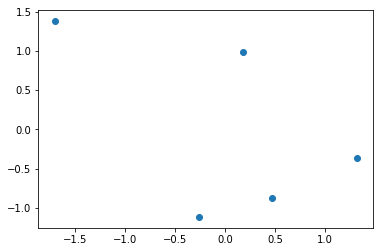

In [36]:
x_vals = []
y_vals = []

for example in list(distances):
    x = float(np.sum(np.array(list(example[2]),dtype=np.float32)))
    y = float(example[0])
    x_vals.append(x)
    y_vals.append(y)
    print("Overall Cosine Distance: %s, Sum Layer Cosine Distance: %s"%(y, x))

plt.scatter(stats.zscore(np.array(x_vals)), stats.zscore(np.array(y_vals)))
plt.show()